In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
from matplotlib import pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('../data/course_prepared.csv', header=0, encoding='unicode_escape')
df.drop(columns='Subj', inplace=True)
df.head()

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled
0,CSC 111,Fall,2019,1,Computer Science,400.0,346.0
1,CSC 115,Fall,2019,1,Computer Science,150.0,130.0
2,CSC 115,Summer,2019,1,Computer Science,115.0,86.0
3,CSC 225,Fall,2019,2,Computer Science,215.0,197.0
4,CSC 225,Summer,2019,2,Computer Science,145.0,63.0


In [3]:
df.sort_values(by=["Course", "Term", "Term Yr"], inplace=True)
df["Enrollment Change"] = df.groupby(["Course", "Term"])["Enrolled"].pct_change() * 100
df["Enrollment Change"] = df["Enrollment Change"].round(2)

df.head(n=15)

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled,Enrollment Change
0,CSC 111,Fall,2019,1,Computer Science,400.0,346.0,NaN
106,CSC 111,Fall,2020,1,Computer Science,277.0,223.0,-35.55
52,CSC 111,Fall,2022,1,Computer Science,475.0,292.0,30.94
127,CSC 111,Fall,2023,1,Computer Science,283.0,220.0,-24.66
178,CSC 111,Spring,2019,1,Computer Science,239.0,198.0,NaN
33,CSC 111,Spring,2020,1,Computer Science,115.0,90.0,-54.55
199,CSC 111,Spring,2022,1,Computer Science,263.0,208.0,131.11
86,CSC 111,Spring,2023,1,Computer Science,138.0,134.0,-35.58
1,CSC 115,Fall,2019,1,Computer Science,150.0,130.0,NaN
107,CSC 115,Fall,2020,1,Computer Science,258.0,214.0,64.62


In [4]:
# Impute the missing Enrollment Change values using the IterativeImputer
impute_pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=42))
])

df["Enrollment Change"] = impute_pipeline.fit_transform(df[["Enrollment Change"]])
df["Enrollment Change"] = df["Enrollment Change"].round(2)

df.head(n=15)

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled,Enrollment Change
0,CSC 111,Fall,2019,1,Computer Science,400.0,346.0,7.67
106,CSC 111,Fall,2020,1,Computer Science,277.0,223.0,-35.55
52,CSC 111,Fall,2022,1,Computer Science,475.0,292.0,30.94
127,CSC 111,Fall,2023,1,Computer Science,283.0,220.0,-24.66
178,CSC 111,Spring,2019,1,Computer Science,239.0,198.0,7.67
33,CSC 111,Spring,2020,1,Computer Science,115.0,90.0,-54.55
199,CSC 111,Spring,2022,1,Computer Science,263.0,208.0,131.11
86,CSC 111,Spring,2023,1,Computer Science,138.0,134.0,-35.58
1,CSC 115,Fall,2019,1,Computer Science,150.0,130.0,7.67
107,CSC 115,Fall,2020,1,Computer Science,258.0,214.0,64.62


<Axes: >

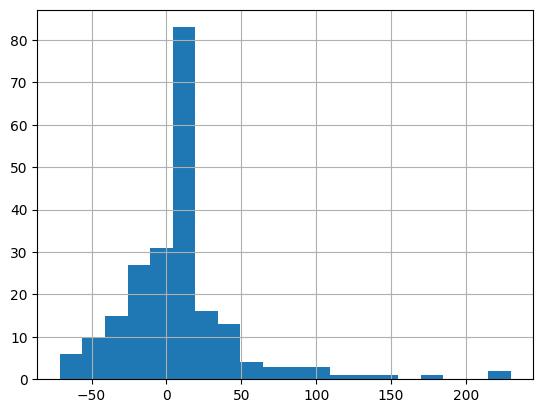

In [5]:
df['Enrollment Change'].hist(bins=20)

In [6]:
# Since our distribution is skewed to the left, we want to shift the distribution to the right
# by subtracting the mean from each value
mean = df.groupby("Course")["Enrollment Change"].transform("mean")
df["Enrollment Change"] -= mean

<Axes: >

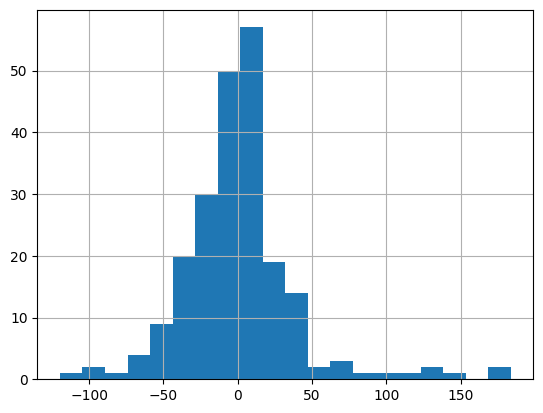

In [7]:
df['Enrollment Change'].hist(bins=20)

In [8]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train : {len(X_train)}, Test: {len(X_test)}")

change = X_train.drop(columns='Enrollment Change', axis='columns')
change_labels = X_train['Enrollment Change'].copy()

Train : 176, Test: 44


In [9]:
# Separate our attributes depending on their desired transformations
num_attribs = ['Class Yr', 'Term Yr']
cat_attribs = ['Term', 'Dept Desc']
log_attribs = ['Cap']
basen_attribs = ['Course']

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('scaler', StandardScaler())
])

basen_pipeline = Pipeline([
    ('base_encoder', ce.BaseNEncoder(base=14, cols=basen_attribs))
])

preprocessing = ColumnTransformer([
    ('numeric_transformer', numeric_pipeline, num_attribs),
    ('categorical_transformer', categorical_pipeline, cat_attribs),
    ('ordinal_transformer', basen_pipeline, basen_attribs),
    ('log_transformer', log_pipeline, log_attribs),
], remainder='passthrough', verbose_feature_names_out=False)

change_prepared = preprocessing.fit_transform(change)

In [10]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

regressors = [
    LinearRegression(),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    KNeighborsRegressor(n_neighbors=20, algorithm='brute', weights='distance'),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100),
    Ridge(alpha=0.5),
    Lasso(alpha=0.1),
]

evaluation_metrics = {}
for idx, regressor in enumerate(regressors):
    regressor = make_pipeline(preprocessing, regressor)
    regressor.fit(change, change_labels)

    predictions = regressor.predict(change)

    rmses = -cross_val_score(regressor, 
                                change, 
                                change_labels,
                                scoring="neg_mean_squared_error",
                                cv=10)
    
    evaluation_metrics[str(regressors[idx])] = [np.mean(rmses), predictions, regressor]

for regressor, out_tuple in evaluation_metrics.items():
    print(f"{regressor}: RMSE score = {out_tuple[0]}")

best_regressor = min(evaluation_metrics, key=evaluation_metrics.get)
print(f"\nBest regressor: {best_regressor}")

LinearRegression(): RMSE score = 1429.5465592365665
ElasticNet(alpha=0.1): RMSE score = 1422.8820988286775
KNeighborsRegressor(algorithm='brute', n_neighbors=20, weights='distance'): RMSE score = 1469.1827990823722
DecisionTreeRegressor(): RMSE score = 2727.3773161660874
RandomForestRegressor(): RMSE score = 1645.704139240559
Ridge(alpha=0.5): RMSE score = 1427.3459189643738
Lasso(alpha=0.1): RMSE score = 1427.5838388683637

Best regressor: ElasticNet(alpha=0.1)


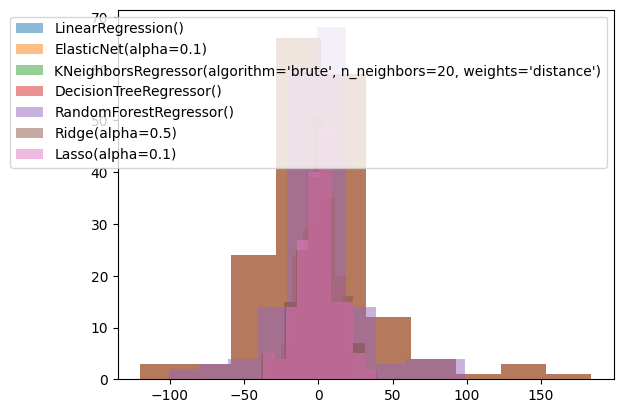

In [11]:
for regressor, out_tuple in evaluation_metrics.items():
    plt.hist(out_tuple[1], alpha=0.5)
    plt.legend(evaluation_metrics.keys())

In [12]:
final_metrics = {}
for regressor, attributes in evaluation_metrics.items():
    change_predictions = attributes[2].predict(X_test)
    final_mse = mean_squared_error(X_test['Enrollment Change'], change_predictions, squared=False)

    final_metrics[regressor] = final_mse
    print(f"{regressor}: Final RMSE score = {final_mse}")

print(f"\nBest Regressor: {min(final_metrics, key=final_metrics.get)}")

LinearRegression(): Final RMSE score = 37.37900492979944
ElasticNet(alpha=0.1): Final RMSE score = 36.97632318911018
KNeighborsRegressor(algorithm='brute', n_neighbors=20, weights='distance'): Final RMSE score = 37.468237662866656
DecisionTreeRegressor(): Final RMSE score = 44.39120013618083
RandomForestRegressor(): Final RMSE score = 34.97805825399879
Ridge(alpha=0.5): Final RMSE score = 37.332154144981125
Lasso(alpha=0.1): Final RMSE score = 37.28058388468229

Best Regressor: RandomForestRegressor()
